Due to the imbalanced nature of our dataset, we have to carefully split the images into a representative training, validation and test set. We decide to have at least one of each bodypart classes in the validation and test sets. Moreover, we artificially augment our imbalanced 105 training images into 7000 by applying different transformations in a way that we generate more images from the unrepresented bodyparts. The filters we use are gaussian noise, spatial transformations and elastic transformations.

In [1]:
from __future__ import division
from sklearn.model_selection import train_test_split
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import create_h5
import cv2
import glob
from random import shuffle
import h5py
import argparse
import rgb2label as gen_label
import scipy.misc
from keras.utils import to_categorical
import random
from keras.preprocessing.image import ImageDataGenerator
from utils import random_crop
from utils import shuffle_together
from utils import balanced_test_val_split

Using TensorFlow backend.


## INPUTS
Main path where images and labels are stored. In data to add, we can select only human data, ct or phantom images. The parameter EXAMPLES_PER_CATEGORY controls the number of images per bodypart after augmenting the images.

In [2]:
main_path = "Data"
data_to_add = ['Humans','CT','Phantom'] 
EXAMPLES_PER_CATEGORY = 6

image_size = 200
train_size = 0.7
n_classes = 3


# output hdf5 file
hdf5_name = '_'.join(data_to_add) 

if(EXAMPLES_PER_CATEGORY == 0):
    hdf5_name = hdf5_name + '_s' + str(image_size) + '.hdf5'

else:
    hdf5_name =  hdf5_name +'_s'+str(image_size)+'_a'+ str(EXAMPLES_PER_CATEGORY)+ '.hdf5'

hdf5_path = ""


## TRAIN TEST VAL SPLIT

In [3]:
# Get balanced body parts split into train test and validation sets
images_train, labels_train, body_train, filenames_train, images_test, labels_test, body_test, \
filenames_test, images_val, labels_val, body_val, filenames_val = \
balanced_test_val_split(main_path, data_to_add, image_size, train_size, n_classes)

# Save hdf5 file without augmentations
create_h5.write_h5("final_noaug.hdf5", images_train, labels_train/255, body_train,filenames_train, \
                   images_test, labels_test/255,body_test,filenames_test,\
images_val, labels_val/255,body_val ,filenames_val)


## AUGMENTATIONS

In [4]:
# Find number of augmentations per image in order to have a balanced training set

unique, counts = np.unique(body_train, return_counts=True)
unique_per_category = dict(zip(unique, counts))
augmentations_per_category = dict(unique_per_category)
for key in unique_per_category:
    augmentations_per_category[key] = int(EXAMPLES_PER_CATEGORY/unique_per_category[key])


In [5]:
#Augmentation templates
translate_max = 0.01
rotate_max = 15
shear_max = 2
crop_min = 0.1
crop_max = 0.4

affine_trasform = iaa.Affine( translate_percent={"x": (-translate_max, translate_max),
                                                 "y": (-translate_max, translate_max)}, # translate by +-
                              rotate=(-rotate_max, rotate_max), # rotate by -rotate_max to +rotate_max degrees
                              shear=(-shear_max, shear_max), # shear by -shear_max to +shear_max degrees
                              order=[1], # use nearest neighbour or bilinear interpolation (fast)
                              cval=125, # if mode is constant, use a cval between 0 and 255
                              mode="reflect",
                              #mode = "",
                              name="Affine",
                             )


spatial_aug = iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.5), affine_trasform])

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

other_aug = iaa.SomeOf((1, None),
        [
            iaa.OneOf([
                iaa.GaussianBlur((0, 0.4)), # blur images with a sigma between 0 and 1.0
            ]),

        ])

elastic_aug = iaa.SomeOf((1, None),
        [
            iaa.OneOf([
                sometimes(iaa.ElasticTransformation(alpha=(50, 60), sigma=16)), 
                # move pixels locally around (with random strengths)
            ]),

        ])


In [6]:
# Create aaugmented set and save train data in it
augmentators = [spatial_aug,other_aug, elastic_aug]
total_images=sum(augmentations_per_category[k]*unique_per_category[k] + unique_per_category[k]\
                 for k in augmentations_per_category)
images_aug = np.zeros((total_images,images_train.shape[1],images_train.shape[2],images_train.shape[3]))
labels_aug = np.zeros((total_images,labels_train.shape[1],labels_train.shape[2],labels_train.shape[3]))
bodypart = np.empty((total_images),dtype = 'S10')
filenames_aug = np.empty((total_images),dtype = 'S60')

images_aug[:images_train.shape[0],...] = images_train
labels_aug[:images_train.shape[0],...] = labels_train/255
bodypart[:images_train.shape[0],...] = body_train
filenames_aug[:images_train.shape[0],...] = filenames_train

In [8]:
# Loop  over the different bodyparts
counter = images_train.shape[0]
counter_block = 0
for i, (k, v) in enumerate(augmentations_per_category.items()):
    # Indices of images with a given bodypart
    indices = np.array(np.where(body_train == k )[0])
    counter_block += len(indices)
    # Number of augmentation per image
    N = int(v)

    for j in indices:
        for l in range(N):
            clear_output(wait=True)
            # Freeze randomization to apply same to labels
            spatial_det = augmentators[0].to_deterministic()
            # to deterministic is needed to apply exactly the same spatial transformation to the data and the labels
            other_augs = augmentators[1]
            # When only adding noise there's no need to perform the transformation on the label
            elastic_det = augmentators[2].to_deterministic()
            
            images_aug[counter,...] = spatial_det.augment_image(images_train[j])
            labels_aug[counter,...] = spatial_det.augment_image(labels_train[j])


            images_aug[counter,...] = elastic_det.augment_image(images_aug[counter,...])
            labels_aug[counter,...]  = elastic_det.augment_image(labels_aug[counter,...] )

            images_aug[counter,...], labels_aug[counter,...] = random_crop(images_aug[counter,...] ,\
                                                                labels_aug[counter,...] ,crop_min,crop_max)
            images_aug[counter,...]  = other_aug.augment_image(images_aug[counter,...] )    


            labels_aug[counter,...]  = to_categorical(np.argmax(labels_aug[counter,...] ,axis=-1), num_classes = 3)
            # only needed if performing elastic transformations
            bodypart[counter] = k 
            
            filenames_aug[counter] = b'aug_' + filenames_train[j]
            print('(Category %s) processing image %i/%i, augmented image %i/%i'%(k,counter_block ,
                                                                                     body_train.shape[0],
                                                                                     l+1, N))
            counter +=1

(Category b'tibia') processing image 98/105, augmented image 6/6


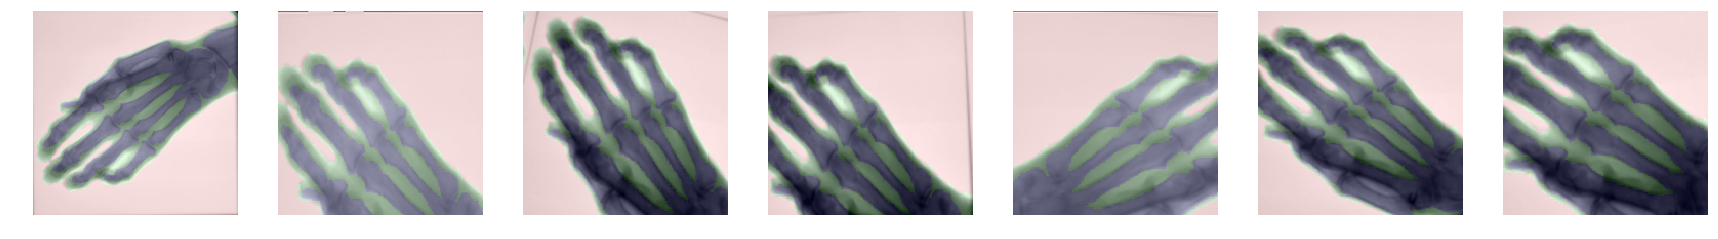

In [16]:
# Show some of the augmented images
original_hand = [i for i, s in enumerate(filenames_aug) if s==b'hand_friday_21_october']
aug_hands =  [i for i, s in enumerate(filenames_aug) if b'aug_hand' in s]
hands = original_hand + aug_hands
fig, ax = plt.subplots(1,len(hands), sharey='row', sharex='col',figsize=(30,30))

for j in range(len(hands)):
    ax[j].imshow(images_aug[hands[j],...,0],cmap='gray')
    ax[j].imshow(labels_aug[hands[j]],alpha=0.1)
    ax[j].axis('off')


In [17]:
# Shuffle the images again
images_aug, labels_aug, bodypart, filenames_aug = shuffle_together(images_aug, labels_aug, bodypart, filenames_aug)

images_test, labels_test, body_test, filenames_test = shuffle_together(images_test, labels_test, body_test, \
                                                                       filenames_test)

images_val, labels_val, body_val, filenames_val = shuffle_together(images_val, labels_val, body_val, filenames_val)

print('Finished playing with cadavers ! ')


Finished playing with cadavers ! 


In [18]:
create_h5.write_h5(hdf5_path + hdf5_name, images_aug, labels_aug, bodypart,filenames_aug, images_test, \
            labels_test/255,body_test,filenames_test,images_val, labels_val/255,body_val ,filenames_val)


print('Saving the hdf5 at %s ...'%hdf5_name)

Saving the hdf5 at Humans_CT_Phantom_s200_a6.hdf5 ...
